In [1]:
%autosave 0

Autosave disabled


# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?
- We had an accuracy of 80%. Is this sufficient? Are there other ways we can evaluate the model?

## 4.1 Evaluation metrics: session overview 

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

Below is just a recap of the last week, loading and preparing the data, then training the model with a decent accuracy of 80%.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
!cp ../03-classification/data-week-3.csv .

In [5]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

Say we have some customers, and we think some are churning.
- We predict 4 will not churn and 2 will churn
- It turns out 2 of the 4 that will not churn did churn, and 1 of the ones that will churn did not
- This means we made 3 correct decisions
- Our **accuracy** is 3/6, or 50%.

**Accuracy:** the fraction of *correct* decisions

Amount of customers:

In [10]:
len(y_val)

1409

For all of these customers, we make a prediction. We assign a probability of 0.0 to 1.0 of the likelihood they will churn. Then, we make a decision.
- If the score is >= 0.5, we classify them as churning. Otherwise, not churning.

The mean of the predictions compared to the validation dataset labels will give us our accuracy:

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

We have an accuracy of ~80%, meaning we have about 1132 correct predictions:

In [12]:
1132/ 1409

0.8034066713981547

We used 0.5 as a decision threshold, but is this actually good? We can try moving this decision threshold.
- Instead of 0.5, we can set it to 0.3 or 0.6 and see if it improves our accuracy

To do this, we can use a use the accuracy score function from scikit-learn. Likely implemented the same way we do it.

In [13]:
from sklearn.metrics import accuracy_score

Example with the 0.5 decision boundary:

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

We can generate many different thresholds between 0 and 1 and see the accuracy for all of them:

In [15]:
# Creates 21 values equally spaced between 0 and 1 inclusive
thresholds = np.linspace(0, 1, 21)

scores = []

print("Acccuracy Scores by Threshold")
print("-----------------------------")
# Get the accuracy for each thrshold
for t in thresholds:
    # Use accuracy with decision boundary t from thresholds
    score = accuracy_score(y_val, y_pred >= t)
    print('t: %.2f accuracy: %.3f' % (t, score))
    scores.append(score)

Acccuracy Scores by Threshold
-----------------------------
t: 0.00 accuracy: 0.274
t: 0.05 accuracy: 0.509
t: 0.10 accuracy: 0.591
t: 0.15 accuracy: 0.666
t: 0.20 accuracy: 0.710
t: 0.25 accuracy: 0.739
t: 0.30 accuracy: 0.760
t: 0.35 accuracy: 0.772
t: 0.40 accuracy: 0.785
t: 0.45 accuracy: 0.793
t: 0.50 accuracy: 0.803
t: 0.55 accuracy: 0.801
t: 0.60 accuracy: 0.795
t: 0.65 accuracy: 0.786
t: 0.70 accuracy: 0.766
t: 0.75 accuracy: 0.744
t: 0.80 accuracy: 0.735
t: 0.85 accuracy: 0.726
t: 0.90 accuracy: 0.726
t: 0.95 accuracy: 0.726
t: 1.00 accuracy: 0.726


We can see the decision threshold of 0.5 is actually the most accurate. However what is most interesting is the accuracy at *t*=0.0 and *t*=1.0

We can also plot this to make this easier to understand:

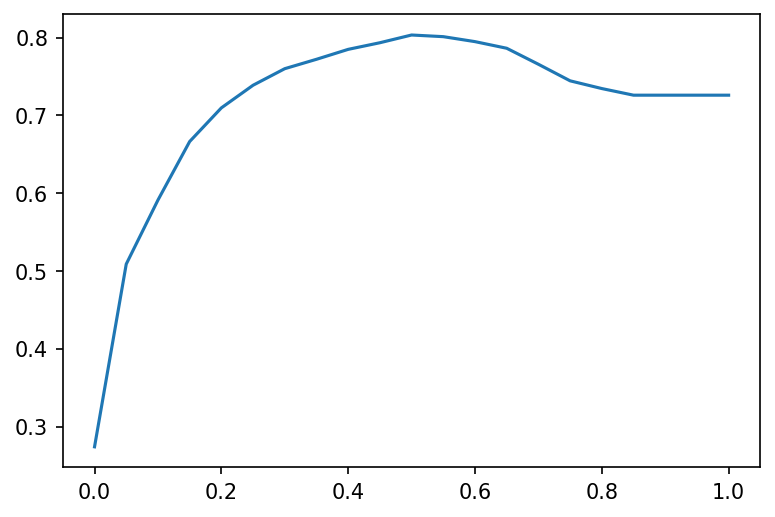

In [16]:
plt.figure(dpi=150)
plt.plot(thresholds, scores)

This is reflected in the graph, as the highest value is right over our 0.5 threshold.
- It is this a coincidence. While logistic regression tries to work such that 0.5 is the most accurate threshold, this is not always the case.

For *t* = 1.0, we say customers are churning if the score >= 1.0. This means every customer is non-churning, as there no values >= 1.0 here.

To show this, we can use a Counter, from collections, to see how many values are True and False

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

The counter only found False values. This predicts no churn for every customer. Notably, the accuracy is fairly decent: 72.6%.

Why bother with our model at 80% accuracy if it only improves from the dummy model by 7%?

This is the **main issue with accuracy**, inability to handle class imbalance. If we look at the distribution of y_val, we can see there are a lot more non-churning users than churning users:

In [19]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [20]:
1 - y_val.mean()

0.7260468417317246

This means 72.6% are non-churning. 

This dummy model says every user will not churn, and this will only be incorrect when a user does churn.
- It will be correct in ~73% of cases for non-churning users
- It will make a mistake for ~27% of cases, the people who are churning.

This is **class imbalance**, as we have around 3x more customers not churning than churning.
- In these situations accuracy is not as useful
- There are other ways to evaluate binary classification models that are more useful in cases of class imbalance

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

Confusion tables are useful to see the true positives, true negatives, false positives and false negatives. These allow more specific insights than just accuracy.
- Confusion tables also provide a way of evaluating a model more thoughtfully when there is class imbalance

Given a decision threshold *t*, we predict churn or no churn based on *t*.
- Among negative classifications, ultimately the customer did or did not churn.
    - If they did not churn, that is correct. This is a **true negative** classification.
    - If they did churn, this is incorrect. This is a **false negative** classification
- Among positive classifications:
    - If they did not churn, that is incorrect. This is a **false positive** classification
    - If they did churn, this is correct. This is a **true positive** classification

<img src="images/4.3-confusion-possibilities.png" alt="drawing" width="1200"/>

*Images from https://www.youtube.com/watch?v=Jt2dDLSlBng&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=42*

To look closer at the confision values, we need to look at where they come from.
- The left circle represents the actual labels. These are churn or not churn
    - This includes TN and FN on the bottom circle.
- The right circle represents the predicted labels. These are based on a decision boundary line in green
    - This represents TP and FP on the bottom circle

![Confusion Pie Graph](images/4.3-confusion-pie-graph.png)

In the graph we can see two correct areas: true negative (left) and true positive (right). Here the predicted value and decision boundary lead to the correct label.
- The upper red slice is False Positive, these were predicted as true but were actually false.
    - We want to minimize false positives if mislabelling positive is unwanted
        - E.g. sending promotions to customers who might not churn is costly
- The lower red slice if False Negative, these were predicted as false but were actually true
    - We want to minimize false negatives if we would rather more true predictions
        - E.g. testing everyone at risk for a dangerous disease when the test is not costly or invasive

Let's take a look at the actual labels

In [21]:
# Let's look at people who are actual churning or not
actual_positive = (y_val == 1)  # Array for each example, True when customer will churn
actual_negative = (y_val == 0)      # Same; True when customer will not churn

Now let's look at our predicted labels and decision boundary

In [22]:
t = 0.5 # Decision threshold
predict_positive = (y_pred >= t) # Same array setup; chooses based on >= or < decision boundary
predict_negative = (y_pred < t)

Let's compare the positive labels

In [23]:
print(predict_positive[:5])
print(actual_positive[:5])

[False False False  True False]
[False False False  True False]


To get True Positives, we need to find where both the predicted and actual positive labels are both True. We can use the **logical &** operator

In [24]:
predict_positive[:5] & actual_positive[:5] # Automatically done elementwise

array([False, False, False,  True, False])

We can do this with the rest of the values

In [25]:
tp = (predict_positive & actual_positive).sum() # True positive is when the the positive is actually positive
tn = (predict_negative & actual_negative).sum() # True negative is when the negative is actually negative

fp = (predict_positive & actual_negative).sum() # False positive is when the predicted positive label is actually negative
fn = (predict_negative & actual_positive).sum() # False negative is when the predicted negative label is actually positive

Let's introduce the **Confusion Table**. This is a 2x2 table of counts with predicted labels on one axis and actual labels on the other.

![Confusion Matrix](images/4.3-confusion-matrix.png)

In [26]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

Thus:
- 922 TN's
- 176 FN's
- 101 FP's
- 210 TP's

We lose some money for the 101 FPs (~32% of emails) as we give promotions to people who would not unsubscribe, and for the 176 FN's (~16% of no email group) as we do not retain these customers

We can also normalize this. Instead of absolute numbers we can use percents

In [27]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

65% and 15% correct, 12% and 8% incorrect.

Accuracy is 80% = 65% + 15%

Recap:
- Can get more specific values than accuracy
- Give more fine-grained insight, especially with class imbalance

## 4.4 Precision and Recall

*Images from https://www.youtube.com/watch?v=gRLP_mlglMM&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=43*

- Intuition behind Precision and Recall
- Implementation

Let's look at Precision and Recall, some metrics we can gather from TP, FP, TN and FN.

In [28]:
# We can express accuracy as:
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.8034066713981547

There are more metrics we can gather from these though.

**Precision**: The fraction of positive predictions that are correct. 

![Precision pie](images/4.4-precision.png)

We are only interested in the red slice on the right, which are all positive predictions. The green subset, TP, as a fraction of the entire red slice is the precision.

Precision = $ {TP \over FP + TP} $

In [29]:
p = tp / (tp + fp)
p

0.6752411575562701

Thus our Precision is ~68%. This means about ~32% of emails were sent in error.

**Recall:** The fraction of correctly identified positive examples 

<img src="images/4.4-recall.png" alt="Recall" width="1200"/>

In the black slice on the right, we have all positive predictions. The green subset, TP, as a fraction of the black slice is the recall. 

Recall = $ {TP \over TP + FN} $

In [30]:
r = tp / (tp + fn)
r

0.5440414507772021

Thus our Recall is ~54%. This means about ~46% of users about to churn were missed.

Recall our accuracy: 80%. It makes our model seem very useful at a glance, but our Precision and Recall were low.
- Sent 33% of promotional emails in error 
- Missed ~46% of of users about to churn.

80% accuracy is misleading. Precision and Recall help for problems with imbalanced classes.

Recap:
- Precision: Fraction of predicted positive labels that were actually correct (TP/TP+FN)
- Recall: Fraction of actual positive labels that we successfully predicted. (TP/TP+FP)

## 4.5 ROC Curves

*Images from https://www.youtube.com/watch?v=dnBZLk53sQI&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=44*

- Receiver Operating Characteristics (ROC) Curve
- True Positive Rate (TPR) and False Positive Rate (FRP)

ROC was originally developed in WWII to evaluate the strength of radar plane detectors.
- Can think of this as an ML problem. If y=1, there is a plane, if y=0, there is not a plane
- The features (*X*) are the signals from the radar

We are interested in two numbers here: TPR and FPR. Both are computed from the confusion matrix.

<img src="images/4.5-confusion-matrix.png" alt="Confusion Matrix" width="1200"/>

The False Positive rate is the entire top row, the True Positive Rate is the entire second row.

FPR = $ {FP \over TN + FP} $

TPR = $ {TP \over FN + TP} $

Expressed with pie charts, we see:
- FPR is the fraction of FPs over all actual negative values
- TPR is the fraction of TPs over all actual positive values


<img src="images/4.5-FPRTPR-ovals.png" alt="Confusion Matrix" width="1200"/>

- To minimize FPR we must minimize FP
- To maximize TPR, we must maximize TP.

Computing TPR and FPR:

In [31]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

Notice is that TPR is the same as Recall.

In [32]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

What we actually need to do, and what ROC curves are actually useful for, is to examine TPR and FPR for all possible decision boundaries.

In [33]:
scores = []

thresholds = np.linspace(0, 1, 101) # Generated 101 steps from [0, 1] at 0.01 intervals

# For every possible decision boundary, check TP, TN, FP, and FN
for t in thresholds:
    # Computing the confusion matrix
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    # Calculate each value and add to list
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

Turn this into a DataFrame to easily produce TPR and FPR:

In [34]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

Let's look at every 10th value:

In [35]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


Both TPR and FPR are decreasing, but FPR is decreasing faster.

Plot the TPR and FPR values along all possible thresholds:

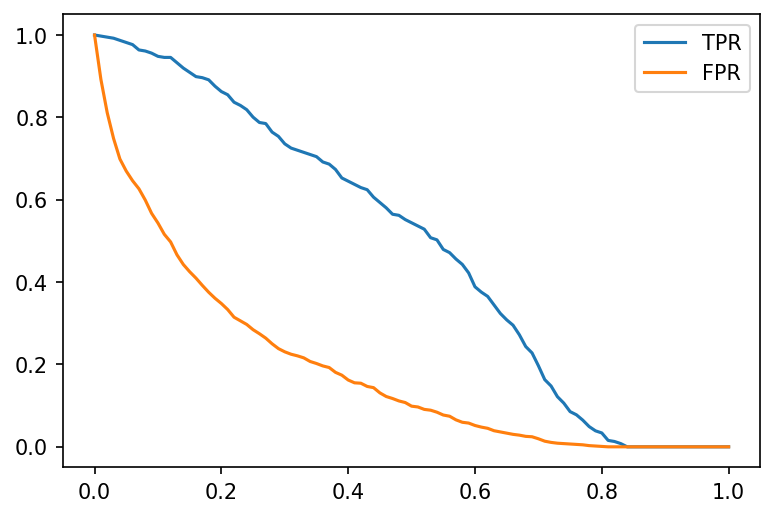

In [36]:
plt.figure(dpi=150)
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

x-axis is the threshold, y-axis is the rate.
- For threshold of 0.0, both TPR and FPR are 1, predicting everyone as churning
    - TPR is 100% because for all churning customers, they are all identified currectly
    - FPR is 100% because for all non-churning customers because we all incorrectly identify as churning
- FPR lowers faster, and we want it to as we want few false positives
- TPR lowers fairly quickly but we want this to be has high as possible.

What if we want to compare at a different point, say 0.5? This is not enough information here.

### Random model

We can produce a random model as a **baseline**. For each customer we can essentially flip a coin

In [37]:
# Flip coin by randomly picking from 0 to 1
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val)) # Uniform distribution with len(y_val) samples
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

Let's see the accuracy. Note that accuracy should be quite low.

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

Just by luck, ~50% of the predictions are correct. Now we want to plot the same rates for this model too.

Take the code above for calculating TPR and FPR:

In [39]:
# Create function taking y_val and y_pred and returning a DataFrame of tp, fp, fn, tn and TPR/FPR
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [41]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


We see that TPR and FPR decrease fairly similarly, by about 0.01 for each threshold 

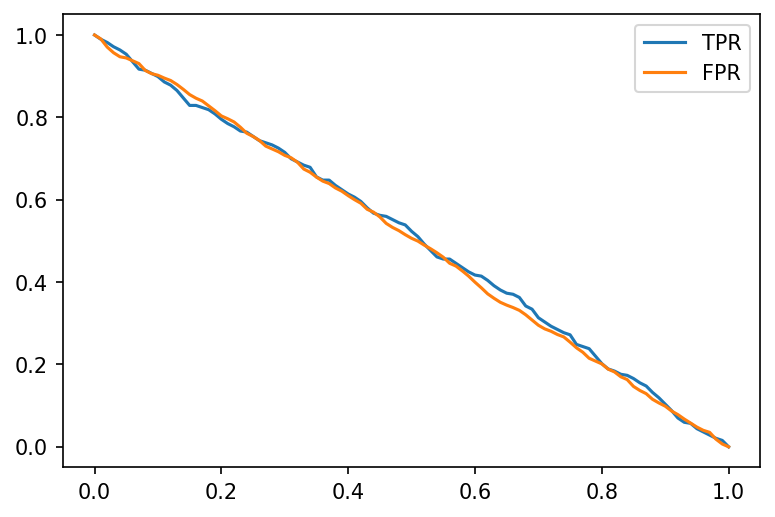

In [42]:
plt.figure(dpi=150)
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

Let's look at some thresholds:
- For *t*=0.6, TPR and FPR are both ~0.4
    - This is like throwing a coin, and saying that for ~60% of cases, this customer is *not* churning
        - In ~40% of cases, this customer is churning
    - We predict a customer is churning with probability ~40%, and with probability ~60% the customer is not churning
        - For about 40% of cases, this model is incorrect for non-churning customers

### Ideal model

A benchmark that gets the correct prediction for every user.
- Say for each customer we have a predicted probability, e.g. [0.3, 0.5, 0.1, 0.8 ...]
- Want to order the customers from smallest to largest probability, e.g. [0.0, 0.01, 0.01, 0.02, ... 0.5, ..., 0.8, 0.9]
- The ideal model orders customers in such a way that first we have all the non-churning customers first, and after a threshold, every customer is churning.
    - Say for threshold *t*, non-churning: [0.0 : t], churning: [t: 0.9]
    - The first 72% do not churn, threshold *t*=0.72, and then last 28% do churn, and accuracy = 100%.

Implementing an ideal model:

In [43]:
# Need to find the number of positive and negative examples
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

First we must create the ideal models probability array:

In [44]:
# Creates array with num_neg repeating 0s and num_pos repeating 1s
# Can think of this as validation set
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

# Need to create predictions. Creating a value for each example/label sampled from [0, 1)
y_ideal_pred = np.linspace(0, 1, len(y_val))

y_ideal, y_ideal_pred

(array([0, 0, 0, ..., 1, 1, 1]),
 array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
        9.98579545e-01, 9.99289773e-01, 1.00000000e+00]))

Finding the decision threshold *t* for 100% accuracy:

In [45]:
1 - y_val.mean()

0.7260468417317246

Positive values should be values above or equal to prediction 0.726

In [46]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

Accuracy is perfect. This model does not exist but it does help us create a baseline for our actual model.

Let's examine the TPR and FPR for the ideal model

In [47]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


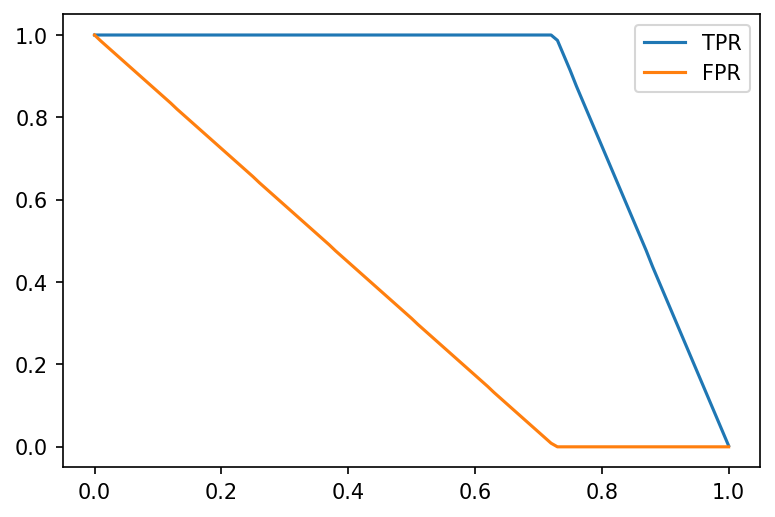

In [48]:
plt.figure(dpi=150)
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

We see the TPR almost always stays around 1.0, this is ideal.
- Starts to lower at 0.726 (*t*) 

No customer ever falsely predicted for churn after *t*

Say for *t* = 0.4, there are approximately 20% non-churning customers that are predicted as churning.

### Putting everything together

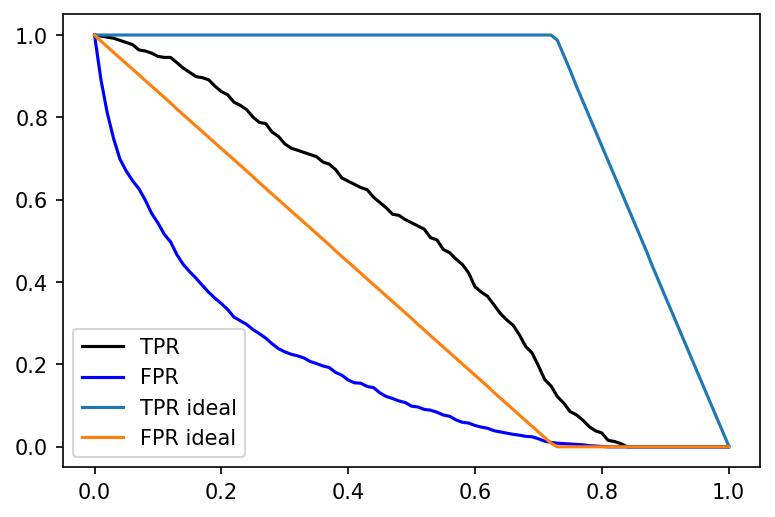

In [49]:
plt.figure(dpi=150)
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# Removed random models
# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

TPR quite from ideal TPR and FPR quite far from ideal FPR.

Plotting against ideal model is not always intuitive, because as we know for our model the best threshold is 0.5 but the best threshold for the ideal model is 0.726.

What we *can* do is plot FPR against to TPR without looking at thresholds.

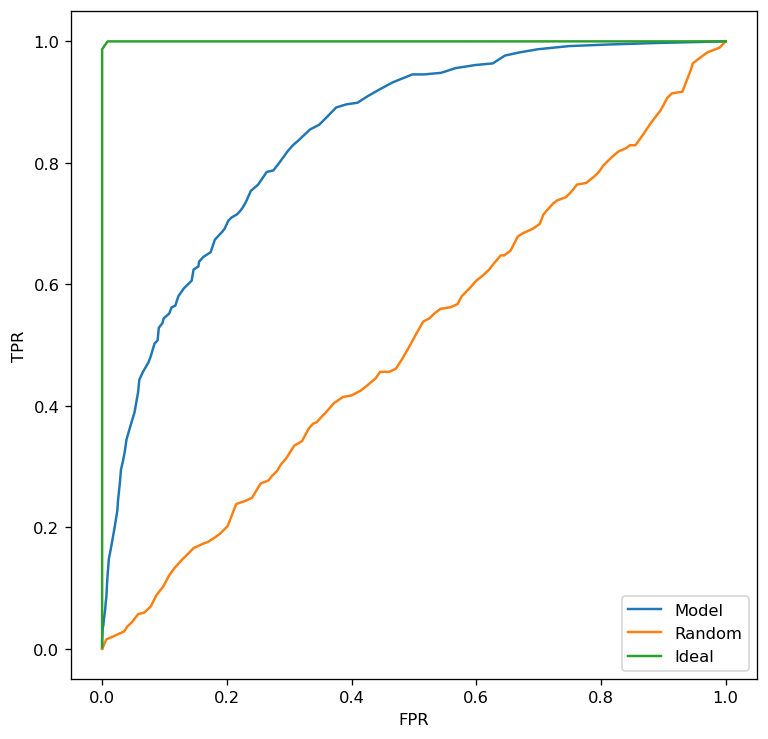

In [50]:
# ROC curves are usually square
plt.figure(figsize=(7.5, 7.5), dpi=118)

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

The spot on the green line where TPR=100% and FPR=0% at *t*=0.726 is what we are aiming for.
- We can call this our **North star**

We do not need these extra calculations however. In practice we can just use the scores and a random function for the random model, and we already know how the ideal model looks:

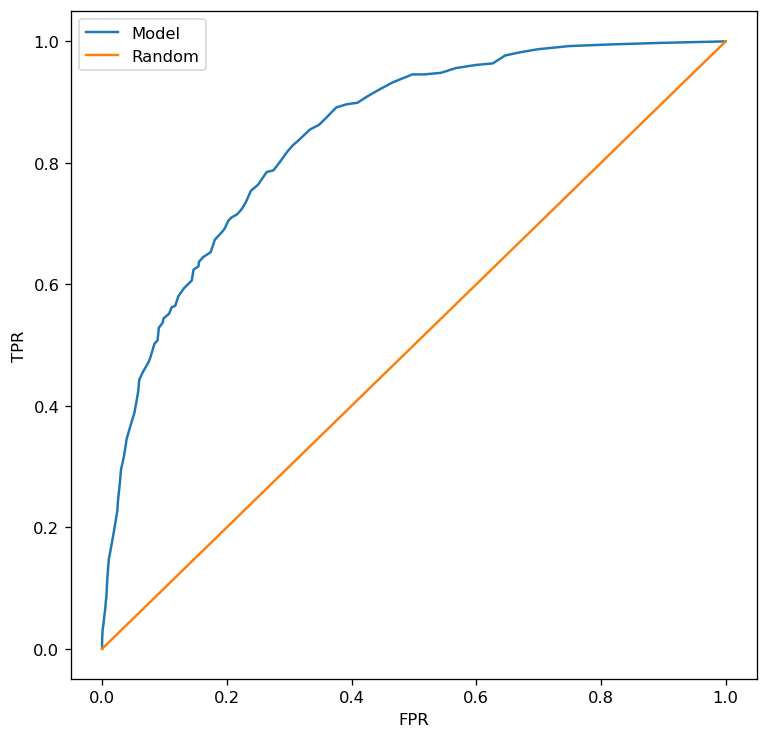

In [51]:
# ROC curves are usually square
plt.figure(figsize=(7.5, 7.5), dpi=118)

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

We know where the North star is and that we want to aim for it. We can keep this in mind and do not have to plot it each time. We want this blue line to be as close as possible to North star and far as possible from random baseline.

Let's understand what is going on here.
- Say we start TPR = FPR = 0. This happens at bigger thresholds like *t*=1.0
    - TPR is always 0 as we do not predict anyone as churning
    - FPR is always 0 as we do every churning prediction is true here
- At TPR = FPR = 1.0 where *t*=0.0.
    - TPR is 100% as we predict everyone as churning
    - FPR is 100% as we do not have any false predictions for FPR
- Say at *t* = 0.07, TPR = 2 and FPR = 0.1. We slowly increase the threshold and predict more customers are churning
    - TPR increases as some of these predictions are correct
        - Recall for the ideal model only the TPR increases, not the FPR
    - FPR also increases as we start making mistakes
- Say as *t* decrease to 0.6 or 0.5, we start predicting more and more customers are churning
    - TPR increases as more of these predictions are correct
    - FPR also increases as we make more mistakes
- For a better model would be a lot closer to ideal line. It would still make some mistakes though and hvae a curve
    - TPR should be high with relatively low FPR as TPR stays close to 100%

<img src="images/4.5-roc-curves.png" alt="Confusion Matrix" width="1200"/>

- Green: good model
- Blue: okay model
- Red: bad model
- Purple: you made a mistake. Perhaps flip your TPR and FPR

Know that for any point along the curves, as you move to the right, *your threshold decreases from 1.0 to 0.1*

Another more interesting metric than ROC curve is the AUC - Area Under the [ROC] Curve. It turns ROC into a single, straightforward metric. We will see this in 4.6

We can also use Scikit-Learn to find ROC and AUC:

In [52]:
from sklearn.metrics import roc_curve

In [53]:
# Function gives you all three values
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

Not interested in thresholds, but can use TPR and FPR to calculate ROC curve:

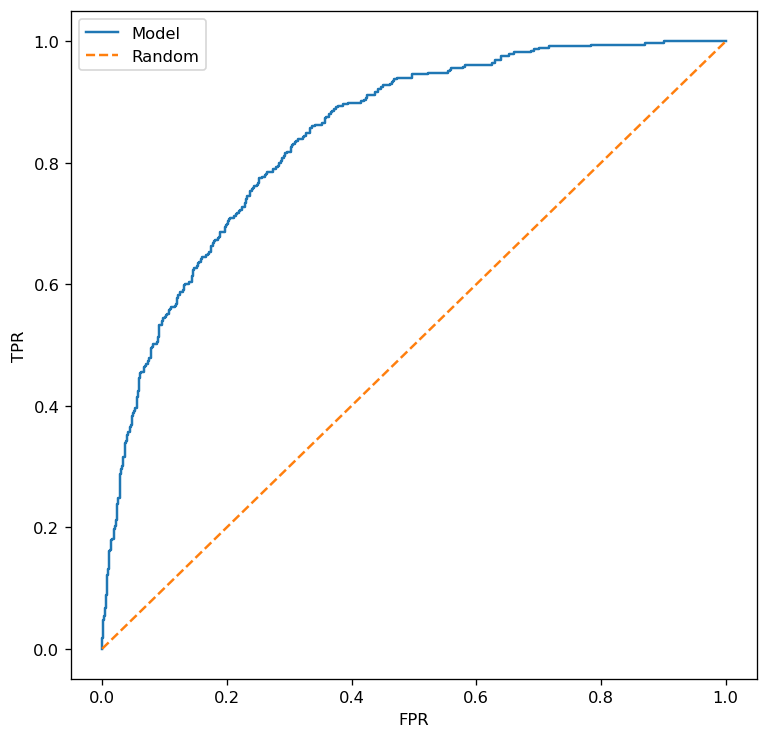

In [54]:
plt.figure(figsize=(7.5, 7.5), dpi=118)

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

More jagged than our curve because it checks thresholds much more specifically, rather than the 100 points we generate. It is more accurate.

Recap:
- True Positive Rate: Number of true positive predictions that are correct (FP/TN+FP)
- False Positive Rate: Number of false positive predictions that are correct (TP/FN+TP)
- ROC curve: FPR plotted against TPR. Want this to be as far up and left as possible for maximal TPR and minimal FPR.

## 4.6 ROC AUC

*Images from https://www.youtube.com/watch?v=hvIQPAwkVZo&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=46*

* Area under the ROC curve - useful metric
* Interpretation of AUC

Recall ROC evaluates how the model performs for every possible decision threshold from 0 to 1.
- The ideal point in the upper left (when TPR=1.0 and FPR=0.0), and we want to be as close as possible to the ideal point
- One of the ways to measure how close we are to this ideal point is with the Area Under the Curve (AUC)

Let's explore AUC:

<img src="images/4.6-AUC.png" alt="AUC" width="1200"/>

The blue model is only okay, and has an AUC of 0.8, but the great model has an AUC of 0.9

<img src="images/4.6-random-model.png" alt="Random Model AUC" width="1200"/>

Random model is basically a straight line. The AUC=0.5 (the overall graph has area 1.0)

<img src="images/4.6-ideal-model.png" alt="Ideal Model AUC" width="1200"/>

Ideal model has the complete possible AUC space. AUC=1.0

Comparing some models:

<img src="images/4.6-auc-comparison.png" alt="AUC comparison" width="1200"/>

We can see how we would compare and evaluate a model based on AUC

To automatically calculate AUC, we can use sklearn metrics:

In [55]:
from sklearn.metrics import auc

Note that this just calculates the area under any curve given *x* and *y*. We need to provide FPR and TPR to get ROC curve AUC:

In [56]:
auc(fpr, tpr)

0.8438479732980819

Let's compare this to our implementation of FPR and TPR:

In [57]:
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

Sklearn's version is more accurate. We only evaluate against 100 thresholds but sklearn calculates against all thresholds the model could have.

We can also check the AUC of the ideal model:

In [58]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

To compute the area under the ROC curve we can use the roc_curve() and auc() functions:

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438479732980819

We can also calculate this all at once with scitkit-learn:

In [60]:
from sklearn.metrics import roc_auc_score

Just need to specify actual values and predictions:

In [61]:
roc_auc_score(y_val, y_pred)

0.8438479732980819

How do we interpet AUC in the context of an actual problem?

Recall the churn example. Say there is already a prediction for each customer.
- E.g. A customer that will not churn has been predicted with a probability of 0.6, and a customer that will churn has been predicted with a probability of 0.5
    - AUC = P(0.5 > 0.60), meaning the AUC is the probability the second customer has a prediction score higher than the first.

AUC is the probability a randomly selected positive example has a higher score than a randomly selected negative example.

We can see this in code. Let's collect all the scores for positive and negative examples:

In [62]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

Let's estimate the probability that a positive example has a higher score than a negative example for our model:

In [63]:
import random

Here for an arbitrary large amount of iterations *n*, we check for two random values if the positive example has a higher score than the negative example:

In [64]:
n = 100000
success = 0 

# Each time gets an index for the negative and positive examples and compares
for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1) # Gets a random int from the range 0 to the number of examples as index
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

# After arbitrary amount of times, estimate probability
success / n

0.84516

This output is quite close to the AUC (0.8438) and we can see that we are approaching it.

Each index corresponds to a different customer, and then we compare whether or not the positive example has a higher score. After doing this enough times, the success rate (probability) should approach the AUC as more probabilities are true than false.

We can implement the same thing in NumPy. Instead of a loop, we can just generate 100,000 negative example indices and 100,000 positive example indices and calculate in a vectorized way:

In [65]:
n = 50000

# Seed for consistency
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n) # Generate n indices
neg_ind = np.random.randint(0, len(neg), size=n)

# The mean of an array of 0s and 1s is just the mean of positive values
(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

Recap:
- Talked about ROC cuve AUC
- This is a good metric as it summarizes FPR and TPR within a fixed range
- Learned AUC, which is also the probability a randomly selected positive example has a higher score than a randomly selected negative example.

## 4.7 Cross-Validation

*Images from https://www.youtube.com/watch?v=BIIZaVtUbf4&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=47*

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

Recall parameter training: we split the dataset into training, validation and test datasets and set the test dataset aside.
- Do not necessarily have to split to validation like this.
- We can instead split into *k* parts (e.g. *k* = 3)
    - We take these 3 parts of the full training dataset, train a model on parts 1 and 2, and then use part 3 for validation
        - Also compute AUC on this validation dataset
- This time, use a different combination of parts, e.g. train a model on parts 1 and 3, and then use part 2 for validation
- Finally use the last combination, e.g. train a model on parts 2 and 3, and then use part 1 for validation


The result of this is that we have 3 AUCs scores and can compute the mean and standard deviation of the AUCs
- Mean shows the average of AUCs, and standard deviation shows how stable the model is.


First create a function for training with DataFrame and labels:

In [66]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [67]:
dv, model = train(df_train, y_train, C=0.001)

Need a function to predict on the validation set and returned predicted labels:

In [68]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [69]:
y_pred = predict(df_val, dv, model)

Now we can generate the folds for K-Fold cross-validaton:

In [70]:
from sklearn.model_selection import KFold

TQDM is a Python package that can provide a progress bar for for-loops and add timing.

In [71]:
from tqdm.auto import tqdm

For multiple regularization parameters *C*, we apply 5-fold CV and report the mean and std of AUC for each value of *C*.

In [72]:
n_splits = 5

for C in tqdm([.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    # Generate n_splits, shuffle and use seed 1 for consistency
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    # Passing a DataFrame to kfold.split() provides a generator that we can iterate 
    #   over and get training and validation indices
    for train_idx, val_idx in kfold.split(df_full_train):
        # kfold.split() returns a list of indices. Need df.iloc[indices] to get the datasets
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        # Train as normal and getting label predictions
        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        # Get AUC score and add it to scores list
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Get mean and std for CV for each value of the regularization parameter C 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.007
C=1 0.840 +- 0.009
C=5 0.841 +- 0.008
C=10 0.841 +- 0.008


The lower values are a bit worse, and 1 almost as good as the others but is the default value, so we go with that.

In [73]:
scores

[0.8437095242207064,
 0.8458420242352005,
 0.832510535821794,
 0.8320150124704228,
 0.8525501239371216]

Now we want to take the full training dataset to train the final model and predict on the test dataset.

In [74]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

A little bit higher than before, which is as we expected. If this change was a little bit lower that would be okay too, as long as results are not wildly different.

## 4.8 Summary

Recap: Used model from last week

* Metric - a single number that describes the performance of a model
    - Accuracy, Precision, Recall, AUC etc
    - Used model from last week to find accuracy metric
* Accuracy - fraction of correct answers; sometimes misleading
    - Used model to evaluate accuracy against different thresholds
        - 0.5 was the best and default threshold
        - At 1.0 we have a dummy model that reads everything as non-churning
            - Difference in that the accuracy was not very different
    - There is quite a class imbalance here, 72% of customers are not churning that is why the model has decent accuracy at *t*=1.0
* Confusion table - a way to describe different types of errors and correct decisions
    - True Positive, True Negative - correct decisions
    - False Positive, False negative - incorrect decisions
* Precision and recall are less misleading when we have class inbalance
    - Precision is the fraction of positive predictions that are correct (our model has 72% precision)
    - Recall is the fraction of correctly identified positive examples (our model is poor, has 64% recall)
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
    - Explored True Positive Rate (TPR) and False Positive Rate (FPR)
    - Modeled FPR against TPR
        - Ideal spot on this graph in the top left, as far from random baseline as possible
* AUC (Area Under the Curve) - here, the AUC of the ROC curve, summarizing FPR and TPR
    - Notably, AUC is the probability that a randomly selected positive example has a higher score than a randomly selected negative example
* K-Fold CV - more reliable estimate for performance (mean + std)
    - A method of dataset splitting to manage over-optimism of model performance
    - Splits full train dataset into K-folds, use 1 fold for evaluation and K-1 to train
    - Use these 10 scores to find average and std scores and see model stability and performance

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week